In [1]:
import sys
from itertools import islice
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Local task dataloaders
sys.path.append('../')
from tasks import task_dataset

# load repe module
from repe import repe_pipeline_registry
repe_pipeline_registry()


2023-10-11 08:05:19.726206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 08:05:20.641219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[2023-10-11 08:05:23,027] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
model_name_or_path = "meta-llama/Llama-2-7b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

rep_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
batch_size = 32
max_length = 2048

rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'

In [38]:
# Define tasks and #shots here

# task, ntrain = 'obqa', 5
# task, ntrain = 'csqa', 7
task, ntrain = 'arc_challenge', 25
# task, ntrain = 'race', 3


dataset = task_dataset(task)(ntrain=ntrain)

Found cached dataset ai2_arc (/data/long_phan/.cache/huggingface/datasets/ai2_arc/ARC-Challenge/1.0.0/1569c2591ea2683779581d9fb467203d9aa95543bb9b75dcfde5da92529fd7f6)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /data/long_phan/.cache/huggingface/datasets/ai2_arc/ARC-Challenge/1.0.0/1569c2591ea2683779581d9fb467203d9aa95543bb9b75dcfde5da92529fd7f6/cache-2ccd5ce024f76298.arrow
Loading cached shuffled indices for dataset at /data/long_phan/.cache/huggingface/datasets/ai2_arc/ARC-Challenge/1.0.0/1569c2591ea2683779581d9fb467203d9aa95543bb9b75dcfde5da92529fd7f6/cache-e30699b38f84da3f.arrow


In [39]:
# Build an unsupervised LAT PCA representation
direction_finder_kwargs= {"n_components": 1}
rep_reader = rep_pipeline.get_directions(
    dataset['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    direction_finder_kwargs=direction_finder_kwargs,
    batch_size=batch_size,
    max_length=max_length,
    padding="longest",
)

In [40]:
# Eval validation
results_val = {layer: {} for layer in hidden_layers}
labels = dataset['val']['labels']
H_tests = rep_pipeline(dataset['val']['data'],
                    rep_token=rep_token, 
                    hidden_layers=hidden_layers, 
                    rep_reader=rep_reader,
                    batch_size=8,
                    max_length=2048,
                    padding="longest")

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    unflattened_H_tests = [list(islice(H_test, sum(len(c) for c in labels[:i]), sum(len(c) for c in labels[:i+1]))) for i in range(len(labels))]

    sign = rep_reader.direction_signs[layer]
    eval_func = np.argmin if sign == -1 else np.argmax
    cors = np.mean([labels[i].index(1) == eval_func(H) for i, H in enumerate(unflattened_H_tests)])

    results_val[layer] = cors
    
    print(f"{layer} : {cors}")
    print("=====")    

-1 : 0.49498327759197325
=====
-2 : 0.5050167224080268
=====
-3 : 0.5016722408026756
=====
-4 : 0.5083612040133779
=====
-5 : 0.5016722408026756
=====
-6 : 0.5250836120401338
=====
-7 : 0.5250836120401338
=====
-8 : 0.5284280936454849
=====
-9 : 0.5016722408026756
=====
-10 : 0.4983277591973244
=====
-11 : 0.5183946488294314
=====
-12 : 0.5217391304347826
=====
-13 : 0.5250836120401338
=====
-14 : 0.5317725752508361
=====
-15 : 0.5050167224080268
=====
-16 : 0.5317725752508361
=====
-17 : 0.46488294314381273
=====
-18 : 0.4916387959866221
=====
-19 : 0.5250836120401338
=====
-20 : 0.3311036789297659
=====
-21 : 0.3177257525083612
=====
-22 : 0.27759197324414714
=====
-23 : 0.2909698996655518
=====
-24 : 0.3076923076923077
=====
-25 : 0.29431438127090304
=====
-26 : 0.27424749163879597
=====
-27 : 0.26421404682274247
=====
-28 : 0.23745819397993312
=====
-29 : 0.2408026755852843
=====
-30 : 0.2408026755852843
=====
-31 : 0.24414715719063546
=====


In [41]:
# Eval Test
results_test = {layer: {} for layer in hidden_layers}
labels = dataset['test']['labels']
H_tests = rep_pipeline(dataset['test']['data'], 
                    rep_token=rep_token, 
                    hidden_layers=hidden_layers, 
                    rep_reader=rep_reader,
                    batch_size=8,
                    max_length=2048,
                    padding="longest")

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    unflattened_H_tests = [list(islice(H_test, sum(len(c) for c in labels[:i]), sum(len(c) for c in labels[:i+1]))) for i in range(len(labels))]

    sign = rep_reader.direction_signs[layer]
    eval_func = np.argmin if sign == -1 else np.argmax
    cors = np.mean([labels[i].index(1) == eval_func(H) for i, H in enumerate(unflattened_H_tests)])

    results_test[layer] = cors
    
    print(f"{layer} : {cors}")
    print("=====") 

-1 : 0.5349829351535836
=====
-2 : 0.5443686006825939
=====
-3 : 0.5494880546075085
=====
-4 : 0.5511945392491467
=====
-5 : 0.5486348122866894
=====
-6 : 0.5469283276450512
=====
-7 : 0.5477815699658704
=====
-8 : 0.5494880546075085
=====
-9 : 0.5494880546075085
=====
-10 : 0.5486348122866894
=====
-11 : 0.5460750853242321
=====
-12 : 0.5486348122866894
=====
-13 : 0.5307167235494881
=====
-14 : 0.5307167235494881
=====
-15 : 0.5136518771331058
=====
-16 : 0.5307167235494881
=====
-17 : 0.4641638225255973
=====
-18 : 0.4974402730375427
=====
-19 : 0.5162116040955631
=====
-20 : 0.3191126279863481
=====
-21 : 0.30887372013651876
=====
-22 : 0.24232081911262798
=====
-23 : 0.257679180887372
=====
-24 : 0.2551194539249147
=====
-25 : 0.2593856655290102
=====
-26 : 0.23293515358361774
=====
-27 : 0.24658703071672355
=====
-28 : 0.257679180887372
=====
-29 : 0.24146757679180889
=====
-30 : 0.26706484641638223
=====
-31 : 0.2508532423208191
=====


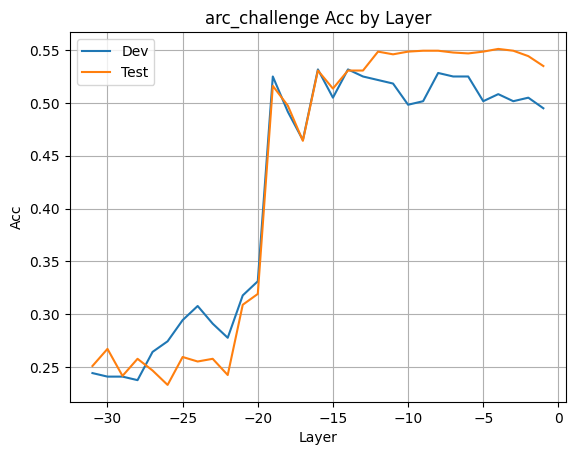

In [42]:
x = list(results_val.keys())
y_val = [results_val[layer] for layer in hidden_layers]
y_test = [results_test[layer] for layer in hidden_layers]


plt.plot(x, y_val, label="Dev")
plt.plot(x, y_test, label="Test")

plt.title(f"{task} Acc by Layer")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend()
plt.grid(True)
plt.show()